In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_euclidian_distance

2025-01-29 10:02:12.831647: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 10:02:13.414713: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 10:02:13.414752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 10:02:13.414782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 10:02:13.433581: I tensorflow/core/platform/cpu_feature_g

In [2]:
from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

In [3]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
prompt_start = "You are the robot in the picture. Your task is to: "

prompt_what_to_move = " To complete this task, do one thing. 1. Point to the location where the relevant object should be moved to."
prompt_end_what_to_move = " Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else."

prompt_where_to_place = " To complete this task, do one thing. 1. Find the relevant object and point to it."
prompt_end_where_to_place = " Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates where the relevant object should be moved to. Dont output anything else."

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
Task: move the pot from the right to the left stove
Task: put potato in pot or pan
Task: take cucumber out of cup
Task: move the banana from the left stove to the sink
Task: pick up the toast and put it to the sink
Task: close the microwave
Task: push the toaster lever
Task: pick up glass cup
Task: take the broccoli and put it between the two right burners
Task: move the pot from the left to the right stove


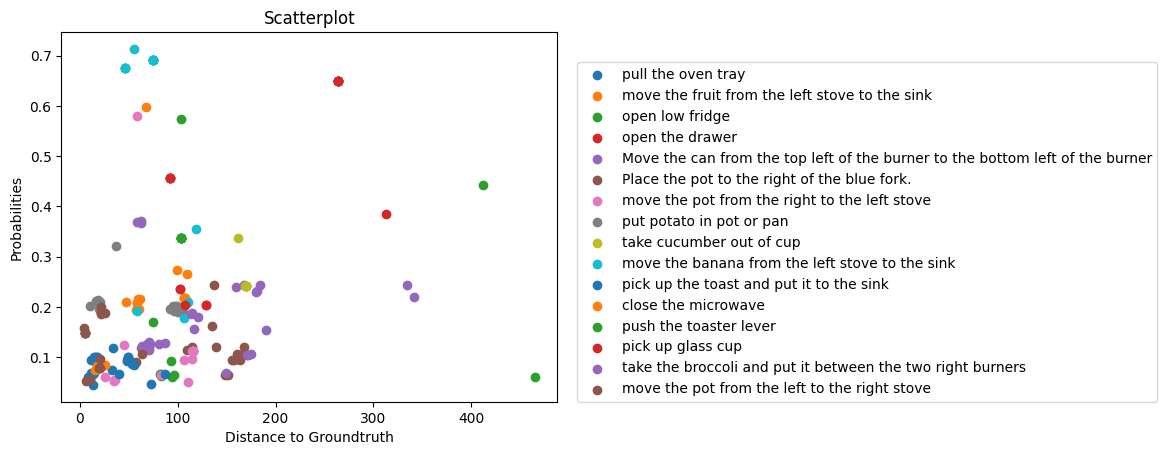

In [10]:
tasks, images, ground_truths, _ = extract_all("../data/base_experiments")
softmax_fn = torch.nn.Softmax(dim=-1)


list_of_distances = []
list_of_probs = []
for i in range(len(tasks)):
    task = tasks[i]
    ground_truth = ground_truths[i]
    prompt_what = prompt_start + task + prompt_what_to_move + prompt_end_what_to_move
    prompt_where = prompt_start + task + prompt_where_to_place + prompt_end_where_to_place
    print(f"Task: {task}")

    distances = [[],[]]
    probs = [[],[]]

    with Image.open(images[i]) as image:
        image_width = image.width
        image_height = image.height
        runs_with_one_coord = 0

        prompts = [prompt_what]
        if (len(ground_truth) == 2):
            prompts.append(prompt_where)

        for k in range(len(prompts)):
            for j in range(8):
                output_text, output, inputs = do_inference(image, prompts[k], model, processor)
                
                coordinates = get_coordinates(output_text, image_width, image_height)
                if len(coordinates) == 1:
                    runs_with_one_coord += 1
                    distances[k].append(calculate_euclidian_distance(coordinates[0], ground_truth[k]))
    
                    coord_probs = calculate_probability_of_coordinates(output, inputs, processor)
    
                    probs[k].append(coord_probs)
                    
                
    list_of_distances.append(distances[0] + distances[1])
    list_of_probs.append(probs[0] + probs[1])
    

    
        
plot_scatter(tasks, list_of_probs, list_of_distances)

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
Task: move the pot from the right to the left stove
Task: put potato in pot or pan
Task: take cucumber out of cup
Task: move the banana from the left stove to the sink
Task: pick up the toast and put it to the sink
Task: close the microwave
Task: push the toaster lever
Task: pick up glass cup
Task: take the broccoli and put it between the two right burners
Task: move the pot from the left to the right stove


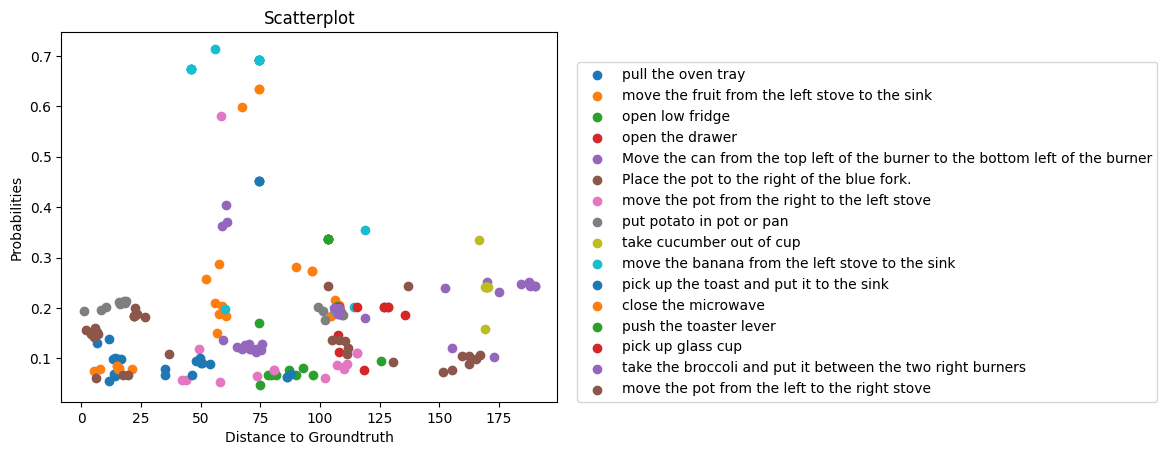

In [12]:
tasks, images, ground_truths, _ = extract_all("../data/base_experiments")
softmax_fn = torch.nn.Softmax(dim=-1)


list_of_distances = []
list_of_probs = []
for i in range(len(tasks)):
    task = tasks[i]
    ground_truth = ground_truths[i]
    prompt_what = prompt_start + task + prompt_what_to_move + prompt_end_what_to_move
    prompt_where = prompt_start + task + prompt_where_to_place + prompt_end_where_to_place
    print(f"Task: {task}")

    distances = [[],[]]
    probs = [[],[]]

    with Image.open(images[i]) as image:
        image_width = image.width
        image_height = image.height

        prompts = [prompt_what]
        if (len(ground_truth) == 2):
            prompts.append(prompt_where)

        for k in range(len(prompts)):
            for j in range(8):
                output_text, output, inputs = do_inference(image, prompts[k], model, processor)
                
                coordinates = get_coordinates(output_text, image_width, image_height)
                if len(coordinates) == 1:
                    dist = calculate_euclidian_distance(coordinates[0], ground_truth[k])
                    if (dist < 250):
                        distances[k].append(dist)
    
                        coord_probs = calculate_probability_of_coordinates(output, inputs, processor)
    
                        probs[k].append(coord_probs)
                    
                
    list_of_distances.append(distances[0] + distances[1])
    list_of_probs.append(probs[0] + probs[1])
    

    
        
plot_scatter(tasks, list_of_probs, list_of_distances)